In [1]:
import pickle
import os
import glob
import numpy as np
import json
from scipy.stats import norm

In [132]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from collections import defaultdict

In [3]:
path = "/home/jenna/sacro_results/results/"

In [4]:
os.listdir(path)

['cf7cf863-929a-4b89-962b-7913869167e4',
 'a90983a1-2329-4019-96e8-949493c3fc24',
 '315ac662-9e95-4dec-80f0-48e244f9f8e1',
 'b71b28f1-7f63-4593-bdb2-9e60dd1ac71e',
 '96c75293-2026-48af-ad99-37281cb9bb3e',
 '436c714b-b588-4894-b68c-1e0f773e5df1',
 '5238ac7b-ad85-488f-b013-9ee4e2064e60',
 'e8d7e0c4-b293-43ce-832f-c37fb8fd3b23',
 'e6a9f8f7-8024-42d5-aad5-ef726d353f3b',
 '26d9e19b-59ed-4bbb-906a-9953b5d2c825',
 'a3347182-4364-43f8-8992-2409b1b66d31',
 'f63b25f4-8df4-4336-8c02-9456eb3c09b0',
 'slinwin_processor.py',
 'e8d3eabc-edd1-414f-9d95-277df742655a',
 'b6701cb1-3a9b-456e-ad73-c6e06eea03ec']

In [5]:
# load pred and true labels. may use mode_ave for comparison
def getLabels(video):
    example_path = path + video
    pred_labels = pickle.load(open(example_path + "/seq_pred.pickle", 'rb'))
#     mode_ave_pred_labels = pickle.load(open(example_path + "/seq_mode_av.pickle", 'rb'))
    true_labels = pickle.load(open(example_path + "/seq_true.pickle", 'rb'))
    return (pred_labels, true_labels)

In [6]:
# load vanilla and extended PKI models results
pki_res_path = "./jenna_model_outputs/"
os.listdir(pki_res_path)

['vanilla_pki_output.pickle',
 'epdp_output.pickle',
 'eptp_output.pickle',
 'fepp_output.pickle']

In [7]:
# vanilla pki results
pki_output = pickle.load(open(pki_res_path + "vanilla_pki_output.pickle", 'rb'))
# extended pki with duration prior results (transition probability)
epdp_output = pickle.load(open(pki_res_path + "epdp_output.pickle", 'rb'))
# extended pki with transition timestamps prior results (phase entry probability)
eptp_output = pickle.load(open(pki_res_path + "eptp_output.pickle", 'rb'))
# fully extended pki with priors
fepp_output = pickle.load(open(pki_res_path + "fepp_output.pickle", 'rb'))

In [8]:
pki_outputs = {"vanilla":pki_output,
               "epdp":epdp_output, 
               "eptp":eptp_output, 
               "fepp":fepp_output}

In [9]:
## get all pred labels and all true labels by video name
pred_label_dict = {}
true_label_dict = {}
for video in os.listdir(path):
    if video == "slinwin_processor.py":
        continue
    pred_labels, true_labels = getLabels(video)
    pred_label_dict[video] = pred_labels
    true_label_dict[video] = true_labels

In [10]:
print(len(pred_label_dict))
print(len(true_label_dict))

14
14


In [11]:
video_names = []
for video in os.listdir(path):
    if video == "slinwin_processor.py":
        continue
    video_names.append(video)

print(len(video_names))    
print(video_names)


14
['cf7cf863-929a-4b89-962b-7913869167e4', 'a90983a1-2329-4019-96e8-949493c3fc24', '315ac662-9e95-4dec-80f0-48e244f9f8e1', 'b71b28f1-7f63-4593-bdb2-9e60dd1ac71e', '96c75293-2026-48af-ad99-37281cb9bb3e', '436c714b-b588-4894-b68c-1e0f773e5df1', '5238ac7b-ad85-488f-b013-9ee4e2064e60', 'e8d7e0c4-b293-43ce-832f-c37fb8fd3b23', 'e6a9f8f7-8024-42d5-aad5-ef726d353f3b', '26d9e19b-59ed-4bbb-906a-9953b5d2c825', 'a3347182-4364-43f8-8992-2409b1b66d31', 'f63b25f4-8df4-4336-8c02-9456eb3c09b0', 'e8d3eabc-edd1-414f-9d95-277df742655a', 'b6701cb1-3a9b-456e-ad73-c6e06eea03ec']


In [51]:
test_folds = {
    1:["e8d7e0c4-b293-43ce-832f-c37fb8fd3b23", "f63b25f4-8df4-4336-8c02-9456eb3c09b0"],
    2:["cf7cf863-929a-4b89-962b-7913869167e4", "b6701cb1-3a9b-456e-ad73-c6e06eea03ec"],
    3:["315ac662-9e95-4dec-80f0-48e244f9f8e1", "a90983a1-2329-4019-96e8-949493c3fc24"],
    4:["e6a9f8f7-8024-42d5-aad5-ef726d353f3b", "96c75293-2026-48af-ad99-37281cb9bb3e"],
    5:["b71b28f1-7f63-4593-bdb2-9e60dd1ac71e", "a3347182-4364-43f8-8992-2409b1b66d31"],
    6:["5238ac7b-ad85-488f-b013-9ee4e2064e60", "436c714b-b588-4894-b68c-1e0f773e5df1"],
    7:["e8d3eabc-edd1-414f-9d95-277df742655a", "26d9e19b-59ed-4bbb-906a-9953b5d2c825"]
}

## Evaluation:
**video comparison**: get accuracy and f1 scores (average of per phase) for each video and compare the trend   
**per-phase evaluation**: all metrics are done per phase basis. final score reported for the metrics is the average score for that phase across all videos

In [111]:
# get accuracy across all folds
num = len(test_folds)
ave_pki_acc = 0
ave_epdp_acc = 0
ave_eptp_acc = 0
ave_fepp_acc = 0

#list to store accuracy for each video for plotting later
pki_acc_list = []
epdp_acc_list = []
eptp_acc_list = []
fepp_acc_list = []

for fold_num in test_folds:
    per_fold_ave_acc_pki = 0
    per_fold_ave_acc_epdp = 0
    per_fold_ave_acc_eptp = 0
    per_fold_ave_acc_fepp = 0
    for video in test_folds[fold_num]:
        true_labels = true_label_dict[video]
        pki_acc =  accuracy_score(true_labels, pki_output[video])
        epdp_acc = accuracy_score(true_labels, epdp_output[video])
        eptp_acc = accuracy_score(true_labels, eptp_output[video])
        fepp_acc = accuracy_score(true_labels, fepp_output[video])
        
        per_fold_ave_acc_pki += pki_acc
        per_fold_ave_acc_epdp += epdp_acc
        per_fold_ave_acc_eptp += eptp_acc
        per_fold_ave_acc_fepp += fepp_acc
        
    # get per fold average
    per_fold_ave_acc_pki /= 2
    per_fold_ave_acc_epdp /= 2
    per_fold_ave_acc_eptp /= 2
    per_fold_ave_acc_fepp /= 2
    
    pki_acc_list.append(per_fold_ave_acc_pki)
    epdp_acc_list.append(per_fold_ave_acc_epdp)
    eptp_acc_list.append(per_fold_ave_acc_eptp)    
    fepp_acc_list.append(per_fold_ave_acc_fepp)
    
    
    ave_pki_acc += per_fold_ave_acc_pki
    ave_epdp_acc += per_fold_ave_acc_epdp
    ave_eptp_acc += per_fold_ave_acc_eptp
    ave_fepp_acc += per_fold_ave_acc_fepp
    
    print("Test fold {}:".format(fold_num))
    print("PKI acc: {}".format(per_fold_ave_acc_pki))
    print("EPDP acc: {}".format(per_fold_ave_acc_epdp))
    print("EPTP acc: {}".format(per_fold_ave_acc_eptp))
    print("FEPP acc: {}".format(per_fold_ave_acc_fepp))
    print()
    
acc_list = [pki_acc_list, epdp_acc_list, eptp_acc_list, fepp_acc_list]
models = ["Vanilla PKI", "EPDP", "EPTP", "FEPP"]
for i in range(4):
    print(acc_list[i])
    mu, sig = norm.fit(acc_list[i])
    print("Model {} has average acc of {} +/- {}".format(models[i], mu*100, sig*100))

Test fold 1:
PKI acc: 0.7925130077590141
EPDP acc: 0.7595381104518485
EPTP acc: 0.8495572797809219
FEPP acc: 0.8349465997261525

Test fold 2:
PKI acc: 0.7807715322001036
EPDP acc: 0.8307849036420465
EPTP acc: 0.8021093449664878
FEPP acc: 0.8064980193551622

Test fold 3:
PKI acc: 0.7419087185918442
EPDP acc: 0.78419707674911
EPTP acc: 0.8164828375105929
FEPP acc: 0.8291359592392517

Test fold 4:
PKI acc: 0.6678062601225565
EPDP acc: 0.7041154535686049
EPTP acc: 0.773223327196515
FEPP acc: 0.78269399467133

Test fold 5:
PKI acc: 0.7645499817373564
EPDP acc: 0.7959816016715286
EPTP acc: 0.8286443225107469
FEPP acc: 0.8323016481607497

Test fold 6:
PKI acc: 0.7772156445376874
EPDP acc: 0.8265606935531435
EPTP acc: 0.793803195315904
FEPP acc: 0.8098708465434078

Test fold 7:
PKI acc: 0.8027526493886772
EPDP acc: 0.8703939558894618
EPTP acc: 0.7887899451353886
FEPP acc: 0.8071064284813958

[0.7925130077590141, 0.7807715322001036, 0.7419087185918442, 0.6678062601225565, 0.7645499817373564, 0.

In [176]:
from matplotlib import rcParams

# figure size in inches
rcParams['font.size'] = 20
rcParams['legend.fontsize']= 20
rcParams['xtick.labelsize']= 20
rcParams['ytick.labelsize']= 20

<Figure size 1080x576 with 0 Axes>

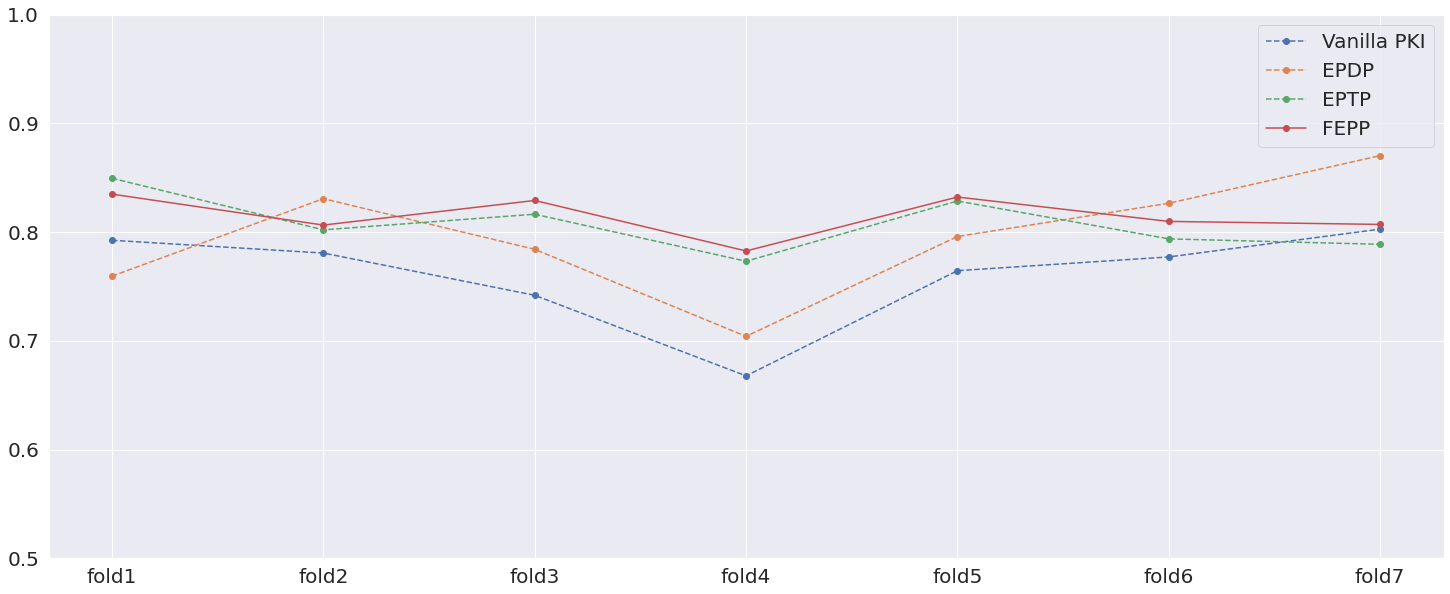

In [192]:
# plot for the accuracies across videos
##############
num = len(test_folds)
figure(figsize=(15, 8))
x = list(range(1, num+1, 1))
plt.figure(figsize=(25, 10))
plt.rc('font', size=25)
labels = ["fold{}".format(i) for i in range(1,8)]
plt.xticks(x, labels=labels)  # Set label locations.
plt.ylim(ymin=0.5)
plt.plot(x, pki_acc_list, '--o',label="Vanilla PKI")
plt.plot(x, epdp_acc_list,'--o', label="EPDP")
plt.plot(x, eptp_acc_list,'--o', label="EPTP")
plt.plot(x, fepp_acc_list,'-o', label="FEPP")
plt.legend()
plt.show()

In [14]:
# Now, you need to loop through every video and document the label list and label freq
# Put above code into function
def get_label_list_and_freq(full_path):
#     pred_labels = pickle.load(open(full_path + "/seq_pred.pickle", 'rb'))
    true_labels = pickle.load(open(full_path + "/seq_true.pickle", 'rb'))
    # scan through the true labels to see whether there are early phases repeating in the later stage
    labels_list = []
    labels_freq = []
    for current_label in true_labels:
        #if list is empty or current label is not the same as the previous label, 
        #then append the current label and frequency
        if (not labels_list) or (current_label != labels_list[-1]):
            labels_list.append(current_label)
            labels_freq.append(1)
            continue
        # for the other cases, simply update frequency
        labels_freq[-1] += 1
    return (labels_list, labels_freq)


# Loop through the subdirectory and extract the label lists and frequencies
data_dict = {}
for subdir in video_names:
    full_path = path + subdir
    labels_list, labels_freq = get_label_list_and_freq(full_path)
    # store the list and corresponding frequency into a dictionary
    labels_dict = {}
    labels_dict["label list"] = labels_list
    labels_dict["label freq"] = labels_freq
    # store the label dictionary into the data dictionary under the corresponding subdirectory
    data_dict[subdir] = labels_dict
    
for vid in data_dict:
    print("{}:".format(vid))
    print("label list:{}\nlabel freq:{}".format(data_dict[vid]["label list"], data_dict[vid]["label freq"]))

cf7cf863-929a-4b89-962b-7913869167e4:
label list:[1, 0, 2, 0, 3, 0, 4, 0, 3, 0, 5]
label freq:[169, 8, 593, 12, 455, 1, 24, 6, 344, 9, 192]
a90983a1-2329-4019-96e8-949493c3fc24:
label list:[1, 0, 2, 0, 3, 0, 4, 0, 5]
label freq:[41, 16, 334, 106, 476, 4, 7, 22, 120]
315ac662-9e95-4dec-80f0-48e244f9f8e1:
label list:[1, 2, 0, 3, 0, 4, 0, 3, 0, 5]
label freq:[84, 231, 23, 544, 24, 26, 39, 192, 7, 184]
b71b28f1-7f63-4593-bdb2-9e60dd1ac71e:
label list:[1, 0, 2, 0, 3, 0, 4, 0, 3, 0, 5]
label freq:[47, 3, 846, 1, 394, 3, 23, 10, 143, 2, 109]
96c75293-2026-48af-ad99-37281cb9bb3e:
label list:[2, 1, 2, 0, 3, 0, 4, 0, 3, 0, 5]
label freq:[146, 101, 254, 17, 550, 1, 73, 14, 190, 15, 266]
436c714b-b588-4894-b68c-1e0f773e5df1:
label list:[1, 0, 2, 0, 3, 0, 4, 0, 3, 0, 5]
label freq:[153, 45, 348, 39, 346, 2, 51, 17, 221, 10, 131]
5238ac7b-ad85-488f-b013-9ee4e2064e60:
label list:[1, 0, 2, 0, 3, 0, 4, 0, 5]
label freq:[54, 1, 728, 28, 379, 14, 21, 62, 151]
e8d7e0c4-b293-43ce-832f-c37fb8fd3b23:
label l

In [15]:
a = np.asarray([1,1,1,1,0,0,0,2,2,2,2,2,2,2])
zero_pos = np.where(a==0)
print(zero_pos)
b = np.asarray([1,1,1,1,5,5,5,5,5,2,2,2,2,2])
np.delete(b,zero_pos)

(array([4, 5, 6]),)


array([1, 1, 1, 1, 5, 5, 2, 2, 2, 2, 2])

In [29]:
### remove zeros in true_labels and the predictions on the corresponding positions
true_label_no_zero = {}
'''
pki_outputs = {"vanilla":pki_output,
               "epdp":epdp_output, 
               "eptp":eptp_output, 
               "fepp":fepp_output}
'''
pki_output_no_zero = {}
fepp_output_no_zero = {}
eptp_output_no_zero = {}
epdp_output_no_zero = {}
pki_output_dict_no_zero = {"vanilla":pki_output_no_zero,
                           "epdp":epdp_output_no_zero, 
                           "eptp":eptp_output_no_zero, 
                           "fepp":fepp_output_no_zero}
    
for video in true_label_dict:
#     print("Video:"+video)
    true_label = np.asarray(true_label_dict[video])
    # get positions of zeros in ground truth
#     print("position of zeros:{}".format(zero_pos))
    zero_pos = np.where(true_label==0)[0]
    # remove zeros from true label
    true_label_no_zero[video] = true_label[true_label != 0]
    
#     print("Number of frames BEFORE removing zero:{}".format(len(true_label)))
#     print("Number of phase zero frames:{}".format(len(zero_pos)))
#     print("Number of frames AFTER removing zero:{}".format(len(true_label_no_zero)))
#     print("True labels AFTER removing zero:{}".format(true_label_no_zero))
    
    for model in pki_outout_dict_no_zero:
        model_output = np.asarray(pki_outputs[model][video])
        model_output_no_zero = np.delete(model_output,zero_pos)
#         print("Length of {} outputs after removing zeros:{}".format(model, len(model_output_no_zero)))
        pki_output_dict_no_zero[model][video] = model_output_no_zero


## Get multi-class confusion matrix

In [145]:
cm = np.array([[0.0]*5]*5)
phase_count = [0]*5
print(cm)
for model in pki_output_dict_no_zero:
    model_pred_dict = pki_output_dict_no_zero[model]
    for video in model_pred_dict:
        y_pred = model_pred_dict[video]
        y_true = true_label_no_zero[video]
        for i in range(len(y_true)):
            phase_count[y_true[i]-1] += 1
            cm[y_true[i]-1][y_pred[i]-1] += 1
            
print(phase_count)
print(cm)
# normalise cm by the phase_count
for i in range(len(phase_count)):
    cm[i] = cm[i]/ phase_count[i]
print(cm)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[5296, 26064, 31740, 1780, 8692]
[[3.7220e+03 1.5070e+03 6.0000e+00 0.0000e+00 6.1000e+01]
 [2.4190e+03 2.2469e+04 8.8000e+02 1.3300e+02 1.6300e+02]
 [0.0000e+00 8.6000e+02 2.8213e+04 9.8300e+02 1.6840e+03]
 [8.3000e+01 1.3900e+02 7.7700e+02 7.1700e+02 6.4000e+01]
 [0.0000e+00 5.5100e+02 1.0130e+03 2.7000e+01 7.1010e+03]]
[[0.70279456 0.28455438 0.00113293 0.         0.01151813]
 [0.09281001 0.86207029 0.03376304 0.00510282 0.00625384]
 [0.         0.02709515 0.88887839 0.03097038 0.05305608]
 [0.04662921 0.07808989 0.43651685 0.40280899 0.03595506]
 [0.         0.06339162 0.11654395 0.0031063  0.81695812]]


In [158]:
from matplotlib import rcParams
rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#EAEAF2',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

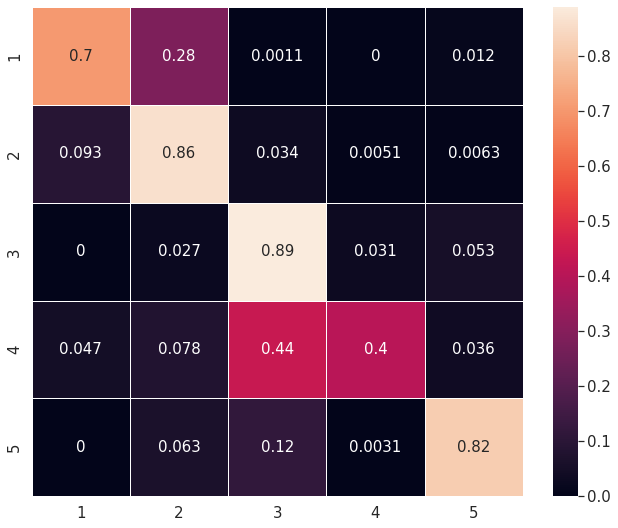

In [161]:
# plot heat map for confusion matrix
import seaborn as sns; sns.set_theme()
sns.set(rc={'figure.figsize':(11,9),
            'font.size':15,
            'xtick.labelsize': 15.0,
            'ytick.labelsize': 15.0,
           })
ax = sns.heatmap(cm, linewidths=.5, annot=True,  xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])

In [30]:
### metrics: per-phase accuracy, per-phase f1 score, per-phase confusion matrix(?) for each model
def evalScorePerPhase(model_output_dict, true_label_dict, data_dict, metric, is_verbose=False):
    scores_dict = {}
    for vid in data_dict:
        if is_verbose:
            print("Video {}".format(vid))
        # add a new default dict for each video to store the per_phase score
        phases_scores = {}

        # get the labels
        true_label = np.asarray(true_label_dict[vid])
        model_output = np.asarray(model_output_dict[vid])
        
        ## storage
        per_phase_f1_score = []
        cur_i = 0
        
#         # use ground truth to separate the phases
#         phases = data_dict[vid]["label list"]
#         nums_of_frames = data_dict[vid]["label freq"]
        
        # loop through each phase and get the accuracy and f1 score
        # for each phase, keep only the phases and changes everything else to a non-phase value
#         for i, phase in enumerate(phases):            
        for phase in range(1, 6):
            phase_true_label = np.where(true_label!=phase, -1, true_label)
            phase_model_output = np.where(model_output!=phase, -1, model_output)

            # change all non-phase values in the prediction results to -1 for binary f1 scoring
#             phase_model_output = np.where(phase_model_output!=phase, -1, phase_model_output)
            if is_verbose and vid == "96c75293-2026-48af-ad99-37281cb9bb3e":
                print("Phase:{}".format(phase))
#                 print("Number of frames for phase {} is {}".format(phase, nums_of_frames[i]))
#                 print("Current index marker:{}".format(cur_i))
                print("True labels:\n {}".format(phase_true_label.tolist()))
#                 print("This is just for checking the index correctness:{}".format(true_label[cur_i-1:cur_i+nums_of_frames[i]+1]))
                print("Model output:\n {}".format(phase_model_output.tolist()))
                print()
            score = 0
            if metric == "f1":
                score = f1_score(phase_true_label, phase_model_output, pos_label=phase, zero_division=0)
            if metric == "precision":
                score = precision_score(phase_true_label, phase_model_output, pos_label=phase, zero_division=0)
            if metric == "recall":
                score = recall_score(phase_true_label, phase_model_output, pos_label=phase, zero_division=0)
            if metric == "acc":
                score = accuracy_score(phase_true_label, phase_model_output)
                
#             print("Phase {} f1 score = {}".format(phase, f1))
#             print()

            # get the average metric value and add it to the dict
            if phase in phases_scores:
                phases_scores[phase] = (phases_scores[phase] + score)/2
            else:
                phases_scores[phase] = score
                
#             cur_i += nums_of_frames[i]

        # add the dict under the video name
        scores_dict[vid] = phases_scores
    return scores_dict

In [31]:
def printPhaseMetricScores(scores):
    for vid in scores:
        print("{}:".format(vid))
        print("phase metric scores:{}".format(scores[vid]))
        print()

In [32]:
# testing: evaluate per-phase f1 score for vanilla pki output
f1_score_vanilla_pki = evalScorePerPhase(pki_output_dict_no_zero["vanilla"], true_label_no_zero, data_dict, "f1", is_verbose=False)
printPhaseMetricScores(f1_score_vanilla_pki)

cf7cf863-929a-4b89-962b-7913869167e4:
phase metric scores:{1: 0.5571428571428572, 2: 0.8602999210734017, 3: 0.8958475153165418, 4: 0.3404255319148936, 5: 0.6936936936936937}

a90983a1-2329-4019-96e8-949493c3fc24:
phase metric scores:{1: 0.6391752577319588, 2: 0.8831168831168831, 3: 0.9055374592833877, 4: 0.0, 5: 0.802675585284281}

315ac662-9e95-4dec-80f0-48e244f9f8e1:
phase metric scores:{1: 0.8876404494382023, 2: 0.7833698030634574, 3: 0.8392156862745098, 4: 0.9056603773584906, 5: 0.6511627906976744}

b71b28f1-7f63-4593-bdb2-9e60dd1ac71e:
phase metric scores:{1: 0.810344827586207, 2: 0.9657210401891253, 3: 0.9302769818529131, 4: 0.37037037037037035, 5: 0.9209302325581395}

96c75293-2026-48af-ad99-37281cb9bb3e:
phase metric scores:{1: 0.47572815533980584, 2: 0.753103448275862, 3: 0.8290535583272193, 4: 0.6727272727272727, 5: 0.6005291005291005}

436c714b-b588-4894-b68c-1e0f773e5df1:
phase metric scores:{1: 0.7560975609756097, 2: 0.8810126582278481, 3: 0.8968036529680365, 4: 0.64462809

In [82]:
# get the average f1 score for each phase for the given model output
# only for five non-transition phases here
def getAveScoreAcrossAllFolds(vid2ScoresDict, test_folds):
    ave_per_fold_score_dict = {}
    for fold_num in test_folds:
        scores = np.asarray([0.0]*5)
        count_phases = np.asarray([0.0]*5)
        # get average value for each fold
        for video in test_folds[fold_num]:
            score_dict = vid2ScoresDict[video]
            for phase in range(1, 6):
                if phase in score_dict:
                    count_phases[phase-1] += 1
                    scores[phase-1] += score_dict[phase]
        scores /= count_phases
        ave_per_fold_score_dict[fold_num] = scores
#     print(scores)
#     print(count_phases)

    return ave_per_fold_score_dict

In [83]:
# test: get average f1 score for vanilla pki output
f1_ave_scores = getAveScoreAcrossAllFolds(f1_score_vanilla_pki, test_folds)
print(f1_ave_scores)

{1: array([0.47022521, 0.84517045, 0.90986173, 0.64725644, 0.68119772]), 2: array([0.5472583 , 0.83361904, 0.92108915, 0.457884  , 0.81792123]), 3: array([0.76340785, 0.83324334, 0.87237657, 0.45283019, 0.72691919]), 4: array([0.59807913, 0.8097395 , 0.75317926, 0.42101972, 0.59785168]), 5: array([0.44683908, 0.74030733, 0.89953213, 0.18518519, 0.46046512]), 6: array([0.57159717, 0.86349483, 0.92609212, 0.57231405, 0.83771542]), 7: array([0.64817205, 0.85582634, 0.91712003, 0.5625    , 0.4192229 ])}


In [84]:
f1_ave_scores_mat = np.asarray(list(f1_ave_scores.values()))
f1_ave_scores_mat

array([[0.47022521, 0.84517045, 0.90986173, 0.64725644, 0.68119772],
       [0.5472583 , 0.83361904, 0.92108915, 0.457884  , 0.81792123],
       [0.76340785, 0.83324334, 0.87237657, 0.45283019, 0.72691919],
       [0.59807913, 0.8097395 , 0.75317926, 0.42101972, 0.59785168],
       [0.44683908, 0.74030733, 0.89953213, 0.18518519, 0.46046512],
       [0.57159717, 0.86349483, 0.92609212, 0.57231405, 0.83771542],
       [0.64817205, 0.85582634, 0.91712003, 0.5625    , 0.4192229 ]])

In [85]:
f1_ave_all_folds = np.sum(f1_ave_scores_mat, axis=0)/len(f1_ave_scores_mat)
f1_ave_all_folds

array([0.57793983, 0.8259144 , 0.88560728, 0.47128423, 0.64875618])

In [86]:
f1_one_val_ave = np.sum(f1_ave_all_folds)/len(f1_ave_all_folds)
f1_one_val_ave

0.6819003844180496

In [113]:
# get average score for each phase across all videos (vector length: 5)
def getAveScoreAcrossAllVid(ave_scores_dict):
    ave_scores_mat = np.asarray(list(ave_scores_dict.values()))
    ave_all_folds = np.sum(ave_scores_mat, axis=0)/len(ave_scores_mat)
    return ave_all_folds

In [120]:
# get average score by fold (vector length: 7)
def getAveScoreByFold(ave_scores_dict):
    ave_scores_mat = np.asarray(list(ave_scores_dict.values()))
#     print("SUM OF SCORES BY FOLD:")
#     print(np.sum(ave_scores_mat, axis=1))
    ave = np.sum(ave_scores_mat, axis=1)/5
    return ave

In [95]:
def printPerFoldAveScores(perFoldScoreDict):
    for fold in perFoldScoreDict:
        print("Fold {}:".format(fold))
        print("Score:{}".format(perFoldScoreDict[fold]))

## Get F1 scores for all four model outputs AND an average across all phases

In [121]:
for model_output_name in pki_outputs:
    f1_scores = evalScorePerPhase(pki_output_dict_no_zero[model_output_name], true_label_no_zero, data_dict, "f1")
#     print(f1_scores)
    # get per-fold average scores
    f1_ave_scores_dict = getAveScoreAcrossAllFolds(f1_scores, test_folds)
    # get average by phase (vector length: 5)
    f1_ave_scores = getAveScoreAcrossAllVid(f1_ave_scores_dict)
    # get average by fold (vector length: 7)
    f1_ave_scores_by_fold = getAveScoreByFold(f1_ave_scores_dict)


    print("Current model:{}".format(model_output_name))
    print("Per fold F1 socres:")
    printPerFoldAveScores(f1_ave_scores_dict)
    print("f1 average scores for individual phase:\n{}".format(f1_ave_scores))
    print("f1 average scores by fold:\n{}".format(f1_ave_scores_by_fold))
    print("Average f1 score across all videos all phases:{}".format(np.sum(f1_ave_scores)/len(f1_ave_scores)))
    print()


Current model:vanilla
Per fold F1 socres:
Fold 1:
Score:[0.47022521 0.84517045 0.90986173 0.64725644 0.68119772]
Fold 2:
Score:[0.5472583  0.83361904 0.92108915 0.457884   0.81792123]
Fold 3:
Score:[0.76340785 0.83324334 0.87237657 0.45283019 0.72691919]
Fold 4:
Score:[0.59807913 0.8097395  0.75317926 0.42101972 0.59785168]
Fold 5:
Score:[0.44683908 0.74030733 0.89953213 0.18518519 0.46046512]
Fold 6:
Score:[0.57159717 0.86349483 0.92609212 0.57231405 0.83771542]
Fold 7:
Score:[0.64817205 0.85582634 0.91712003 0.5625     0.4192229 ]
f1 average scores for individual phase:
[0.57793983 0.8259144  0.88560728 0.47128423 0.64875618]
f1 average scores by fold:
[0.71074231 0.71555434 0.72975543 0.63597386 0.54646577 0.75424272
 0.68056827]
Average f1 score across all videos all phases:0.6819003844180496

Current model:epdp
Per fold F1 socres:
Fold 1:
Score:[0.37482068 0.85025539 0.87255629 0.33289474 0.47968464]
Fold 2:
Score:[0.76559908 0.88717014 0.91229193 0.14655172 0.76354167]
Fold 3:
Sc

## Get PRECISION score for all four model outputs AND an average across all phases

In [162]:
precision_scores = {}
precisions_by_fold = {}
for model_output_name in pki_outputs:
    scores = evalScorePerPhase(pki_output_dict_no_zero[model_output_name], true_label_no_zero, data_dict, "precision")
#     printPhaseMetricScores(scores)
    # get per fold precision score
    ave_scores_dict = getAveScoreAcrossAllFolds(scores, test_folds)
    # get average score across all folds
    ave_scores = getAveScoreAcrossAllVid(ave_scores_dict)
    # get average by fold (vector length: 7)
    ave_scores_by_fold = getAveScoreByFold(ave_scores_dict)


    # store
    precision_scores[model_output_name] = ave_scores_dict
    precisions_by_fold[model_output_name] = ave_scores_by_fold
    
    # print
    print("Current model:{}".format(model_output_name))
    print("Per fold precision socres:")
    printPerFoldAveScores(ave_scores_dict)
    print("Average precision scores for individual phase:\n{}".format(ave_scores))
    print("Average precision scores BY FOLD:\n{}".format(ave_scores_by_fold))
    # get mean and std for the score
    mu, sig = norm.fit(ave_scores_by_fold)
    print("Model {} has average score of {} +/- {}".format(model_output_name, mu*100, sig*100))
    print()
    
print(precision_scores)

Current model:vanilla
Per fold precision socres:
Fold 1:
Score:[0.62739965 0.76337466 0.88522994 0.97916667 0.78298368]
Fold 2:
Score:[0.53710554 0.86156763 0.97973256 0.51051213 0.76897019]
Fold 3:
Score:[0.69699848 0.8782872  0.96482875 0.44444444 0.5778622 ]
Fold 4:
Score:[0.51484594 0.92       0.81935143 0.54761905 0.6520872 ]
Fold 5:
Score:[0.36999147 0.6645422  0.91012425 0.16129032 0.46698113]
Fold 6:
Score:[0.62       0.87200138 0.94015794 0.77857143 0.87606838]
Fold 7:
Score:[0.48345202 0.90653569 0.99795918 0.41538462 0.36347518]
Average precision scores for individual phase:
[0.54997044 0.83804411 0.92819772 0.54814124 0.64120399]
Average precision scores BY FOLD:
[0.80763092 0.73157761 0.71248422 0.69078072 0.51458588 0.81735983
 0.63336134]
Model vanilla has average score of 70.11115006445134 +/- 9.666303811014938

Current model:epdp
Per fold precision socres:
Fold 1:
Score:[0.89082569 0.74442144 0.8034095  0.70588235 0.89855072]
Fold 2:
Score:[0.8654902  0.81757108 0.9265

In [193]:
# plots
def plot(score_by_fold):
##############
    names = {"vanilla":"Vanilla PKI",
             "eptp":"EPTP",
             "epdp":"EPDP",
             "fepp":"FEPP",
            }
    num = 7
    figure(figsize=(15, 8))
    x = list(range(1, num+1, 1))
    plt.figure(figsize=(25, 12))
    plt.rc('font', size=20)
    labels = ["fold{}".format(i) for i in range(1,8)]
    plt.xticks(x, labels=labels)  # Set label locations.
    plt.ylim(ymin=0.5)
    for model in score_by_fold:
        if model == "fepp":
            plt.plot(x, score_by_fold[model], '-o',label=names[model])
            continue
        plt.plot(x, score_by_fold[model], '--o',label=names[model])
    plt.legend()
    plt.show()

<Figure size 1080x576 with 0 Axes>

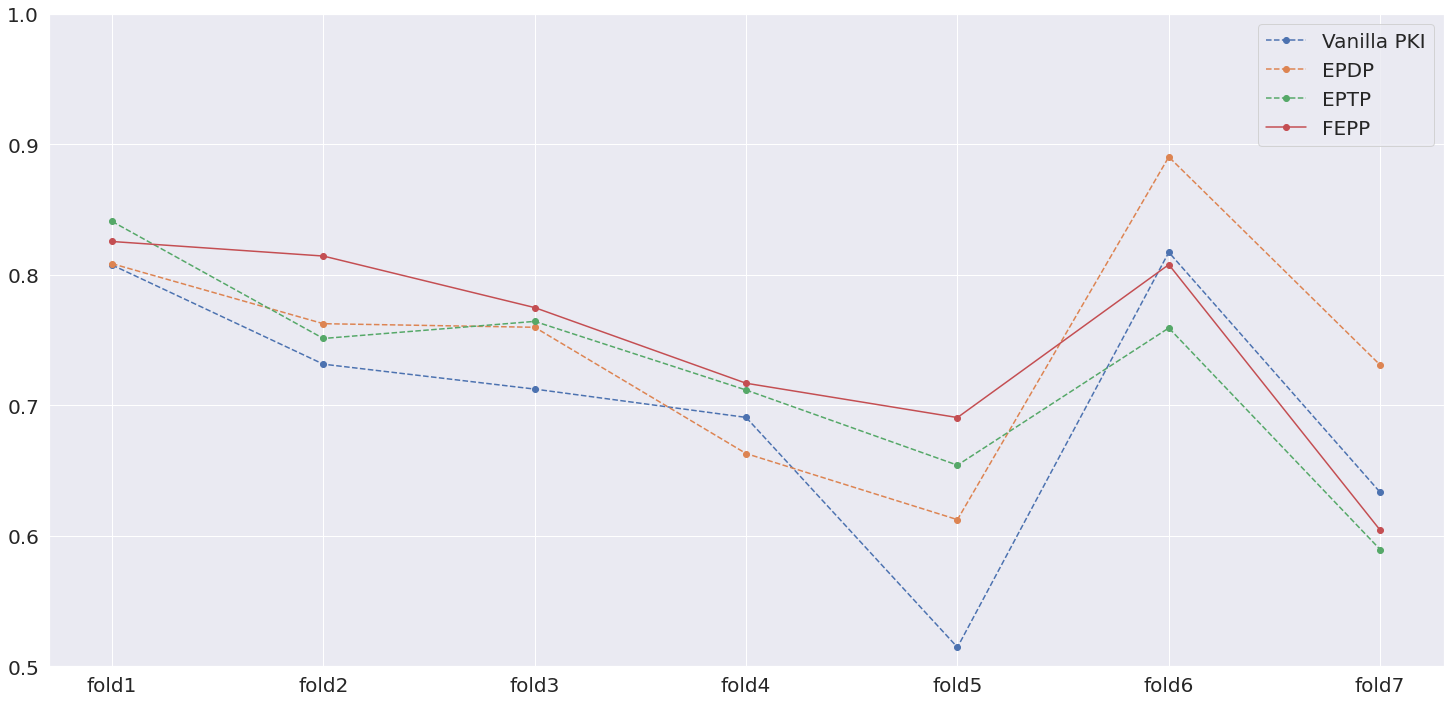

In [194]:
plot(precisions_by_fold)

## Get RECALL score for all four model outputs AND an average across all phases


In [187]:
recall_scores = {}
recalls_by_fold = {}
for model_output_name in pki_outputs:
    scores = evalScorePerPhase(pki_output_dict_no_zero[model_output_name], true_label_no_zero, data_dict, "recall")
    # get per fold precision score
    ave_scores_dict = getAveScoreAcrossAllFolds(scores, test_folds)
    # get average score across all folds
    ave_scores = getAveScoreAcrossAllVid(ave_scores_dict)
     # get average by fold (vector length: 7)
    ave_scores_by_fold = getAveScoreByFold(ave_scores_dict)


    # store
    recall_scores[model_output_name] = ave_scores_dict
    recalls_by_fold[model_output_name] = ave_scores_by_fold
    
    # print
    print("Current model:{}".format(model_output_name))
    print("Per fold recall socres:")
    printPerFoldAveScores(ave_scores_dict)
    print("Average recall scores for individual phase:\n{}".format(ave_scores))
    print("Average recall scores BY FOLD:\n{}".format(ave_scores_by_fold))
    # get mean and std for the score
    mu, sig = norm.fit(ave_scores_by_fold)
    print("Model {} has average score of {} +/- {}".format(model_output_name, mu*100, sig*100))
    print()

    
print(recall_scores)

Current model:vanilla
Per fold recall socres:
Fold 1:
Score:[0.44764356 0.96721574 0.93991698 0.59375    0.62377907]
Fold 2:
Score:[0.71617069 0.82052648 0.87036343 0.55913978 0.88003326]
Fold 3:
Score:[0.84828688 0.79463152 0.8014763  0.46153846 0.99456522]
Fold 4:
Score:[0.74257426 0.72337635 0.69693827 0.63437704 0.65698219]
Fold 5:
Score:[0.57142857 0.92446636 0.88957281 0.2173913  0.45412844]
Fold 6:
Score:[0.80392157 0.87912088 0.91319168 0.54901961 0.80276528]
Fold 7:
Score:[0.98529412 0.81079508 0.85054177 1.         0.49516908]
Average recall scores for individual phase:
[0.73075995 0.8457332  0.85171446 0.57360231 0.70106036]
Average recall scores BY FOLD:
[0.71446107 0.76924673 0.78009967 0.69084962 0.6113975  0.7896038
 0.82836001]
Model vanilla has average score of 74.05740579613251 +/- 6.796603899301756

Current model:epdp
Per fold recall socres:
Fold 1:
Score:[0.28085149 0.99583225 0.95826127 0.24592391 0.33760804]
Fold 2:
Score:[0.71398955 0.97486647 0.89860202 0.091397

<Figure size 1080x576 with 0 Axes>

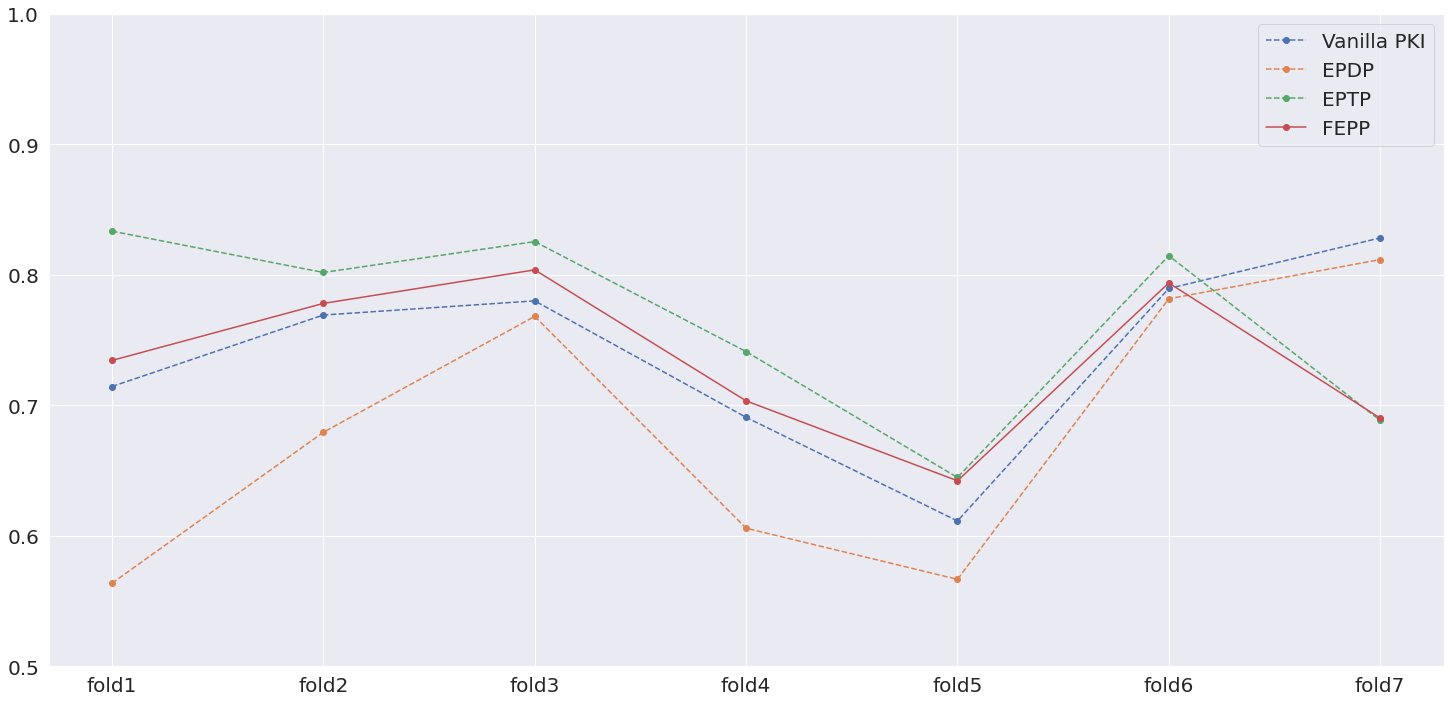

In [195]:
plot(recalls_by_fold)

## Get AVERAGED F1 scores for all four model outputs using AVERAGED PRECISION and RECALL

In [196]:
# Calculate f1 score manually using the averaged calculated precision and recall
f1_scores = {}
f1_scores_by_fold = {}
for model in precision_scores:
    precisions_per_fold_dict = precision_scores[model]
    recalls_per_fold_dict = recall_scores[model]
    f1s_per_fold_dict= {}
    # get per fold f1 scores
    for fold_num in recalls_per_fold_dict:
        precisions = precisions_per_fold_dict[fold_num]
        recalls = recalls_per_fold_dict[fold_num]
        f1s = [0.0]*5
        # get f1 for five phases for current fold
        for i in range(5):
            f1s[i] = (2*precisions[i]*recalls[i])/(precisions[i]+recalls[i])
        f1s_per_fold_dict[fold_num] = f1s
    # add per fold f1 to the model
    f1_scores[model] = f1s_per_fold_dict
    #ave by phase (len 5)
    ave_scores = getAveScoreAcrossAllVid(f1s_per_fold_dict)
     # get average by fold (vector length: 7)
    ave_scores_by_fold = getAveScoreByFold(f1s_per_fold_dict)
    f1_scores_by_fold[model] = ave_scores_by_fold



    print("Model {}".format(model))
    print("Per fold f1 socres:")
    printPerFoldAveScores(f1s_per_fold_dict)
    print("Average f1 scores for individual phase:\n{}".format(ave_scores))
    print("Average f1 scores BY FOLD:\n{}".format(ave_scores_by_fold))
    # get mean and std for the score
    mu, sig = norm.fit(ave_scores_by_fold)
    print("Model {} has average score of {} +/- {}".format(model, mu*100, sig*100))
    print()
    

Model vanilla
Per fold f1 socres:
Fold 1:
Score:[0.5224932580017712, 0.8532902805562913, 0.9117541659065382, 0.7392384105960265, 0.6943727138636662]
Fold 2:
Score:[0.613845913056625, 0.8405463731337554, 0.9218152967297033, 0.5337206214673956, 0.8207615868769322]
Fold 3:
Score:[0.7652368682681149, 0.8343677234712825, 0.8755988954227083, 0.4528301886792453, 0.7309992646638948]
Fold 4:
Score:[0.6080884363944348, 0.80992554272474, 0.7532035193433724, 0.5878140439398717, 0.6545255402521603]
Fold 5:
Score:[0.44915912031047867, 0.7732455632834674, 0.8997311862863953, 0.18518518518518517, 0.4604651162790698]
Fold 6:
Score:[0.7000826218672543, 0.8755466568701294, 0.9264786328130766, 0.6439497837324613, 0.8378165074145775]
Fold 7:
Score:[0.6486382091405033, 0.8559966277913738, 0.9183722303100544, 0.5869565217391305, 0.4192229038854806]
Average f1 scores for individual phase:
[0.61536349 0.83470268 0.8867077  0.53281354 0.65973766]
Average f1 scores BY FOLD:
[0.74422977 0.74613796 0.73180659 0.68

<Figure size 1080x576 with 0 Axes>

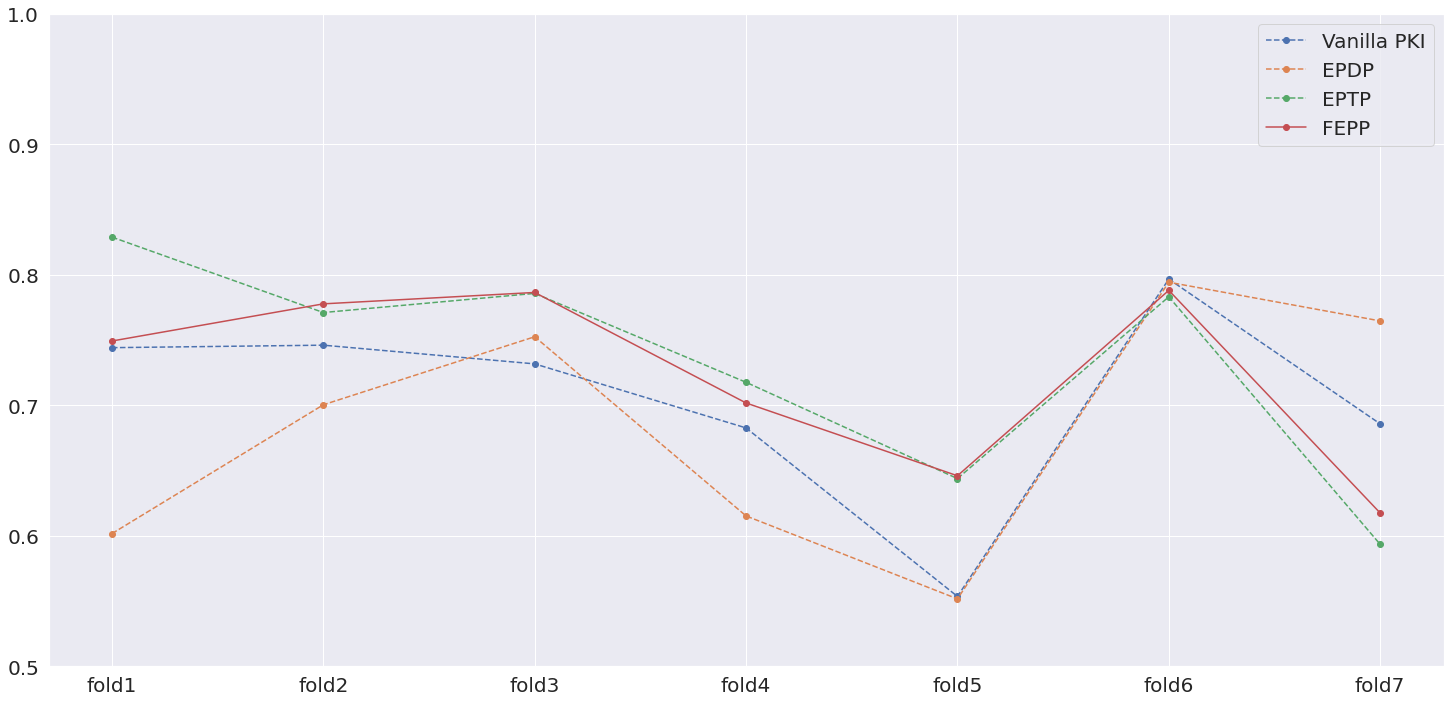

In [197]:
plot(f1_scores_by_fold)

## Plots for averaged model f1 scores per fold

In [198]:
print(f1_scores)

{'vanilla': {1: [0.5224932580017712, 0.8532902805562913, 0.9117541659065382, 0.7392384105960265, 0.6943727138636662], 2: [0.613845913056625, 0.8405463731337554, 0.9218152967297033, 0.5337206214673956, 0.8207615868769322], 3: [0.7652368682681149, 0.8343677234712825, 0.8755988954227083, 0.4528301886792453, 0.7309992646638948], 4: [0.6080884363944348, 0.80992554272474, 0.7532035193433724, 0.5878140439398717, 0.6545255402521603], 5: [0.44915912031047867, 0.7732455632834674, 0.8997311862863953, 0.18518518518518517, 0.4604651162790698], 6: [0.7000826218672543, 0.8755466568701294, 0.9264786328130766, 0.6439497837324613, 0.8378165074145775], 7: [0.6486382091405033, 0.8559966277913738, 0.9183722303100544, 0.5869565217391305, 0.4192229038854806]}, 'epdp': {1: [0.4270625445674291, 0.8519664490721579, 0.8740296097542712, 0.36476614325300194, 0.4908074219466029], 2: [0.7824740470575652, 0.889317045874417, 0.9123471737650225, 0.14655172413793105, 0.7716145105715165], 3: [0.921384814870815, 0.9088706

## plot model smoothing for a particular fold

### fold 3 and fold 6


In [222]:
names = {"vanilla":"Vanilla PKI",
             "eptp":"EPTP",
             "epdp":"EPDP",
             "fepp":"FEPP",
            }

color = {
    "vanilla":"tab:olive",
     "eptp":"tab:green",
     "epdp":"tab:cyan",
     "fepp":"tab:red",
    
}

In [224]:
def plotCnnPred(cnn_output, true_labels):
    figure(figsize=(22, 8))
    x = list(range(len(true_labels)))
    plt.plot(x, true_labels, label="True labels", color='b')
    plt.plot(x, cnn_output, label="CNN predictions", color='tab:orange')
    plt.legend()
    plt.show()

In [225]:
def plotOutput(model, model_output, true_labels):
    figure(figsize=(22, 8))
    x = list(range(len(true_labels)))
    plt.plot(x, true_labels, label="True labels")
    plt.plot(x, model_output, label="{} outputs".format(names[model]), color=color[model])
    plt.legend()
    plt.show()

Fold 3 Video 315ac662-9e95-4dec-80f0-48e244f9f8e1


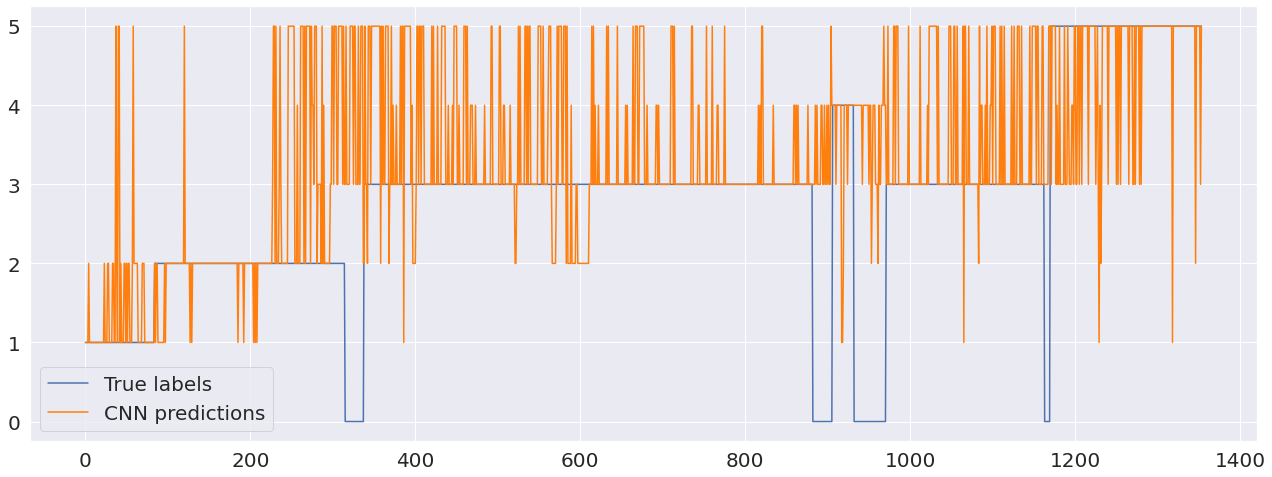

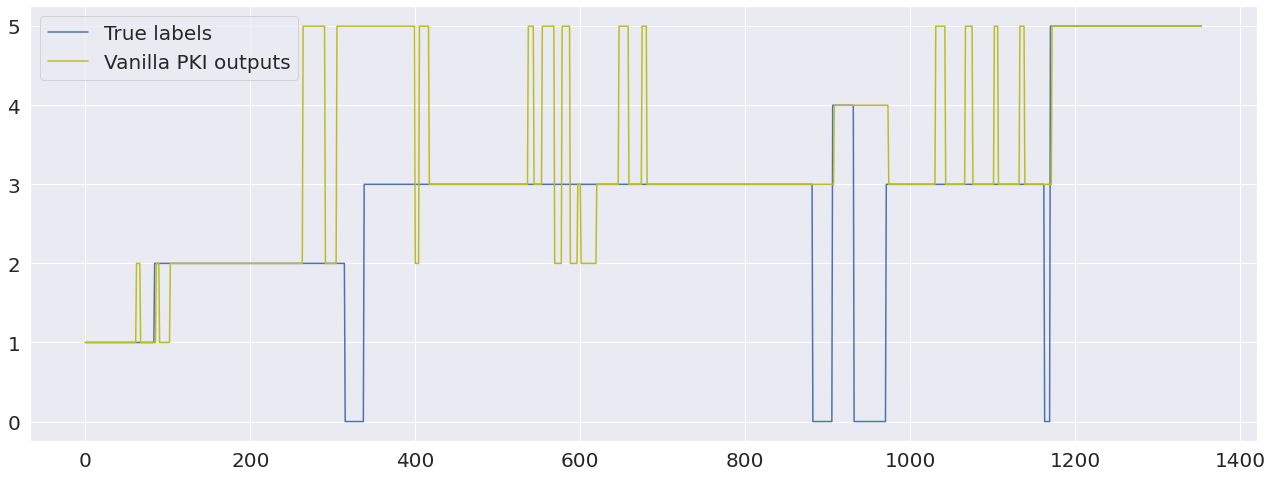

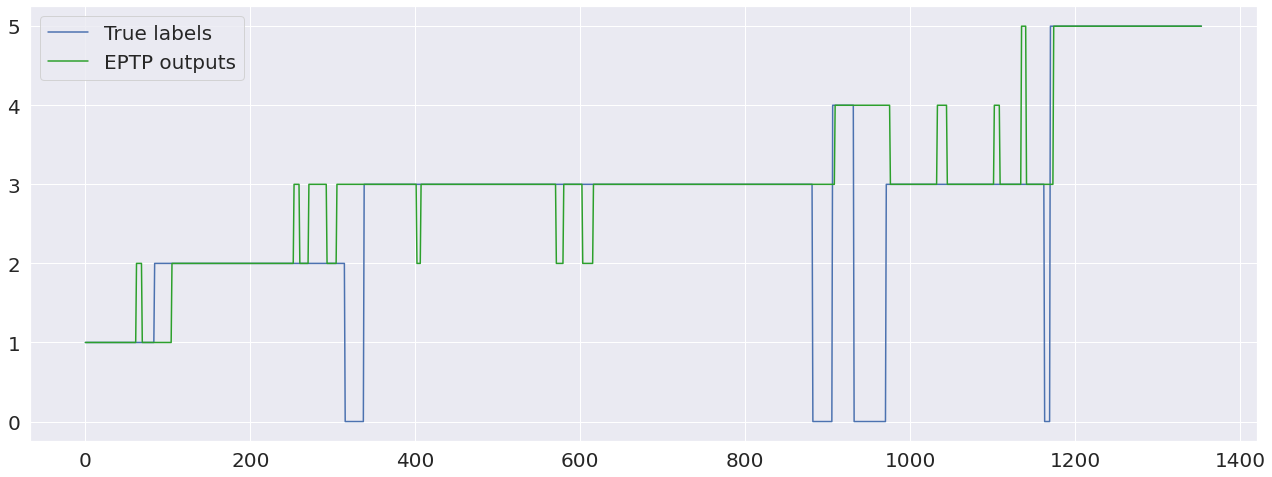

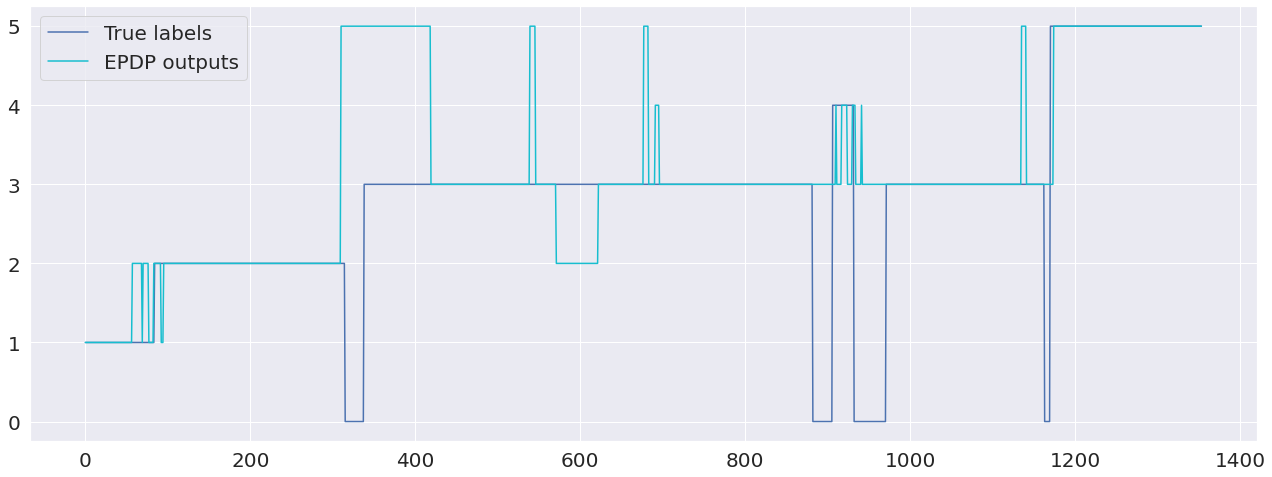

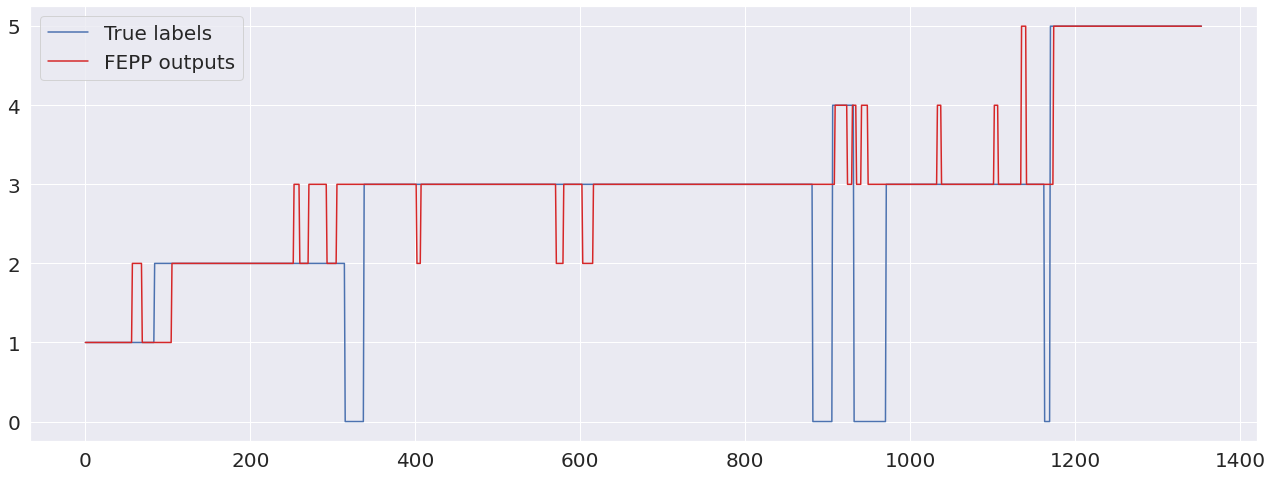

Fold 3 Video a90983a1-2329-4019-96e8-949493c3fc24


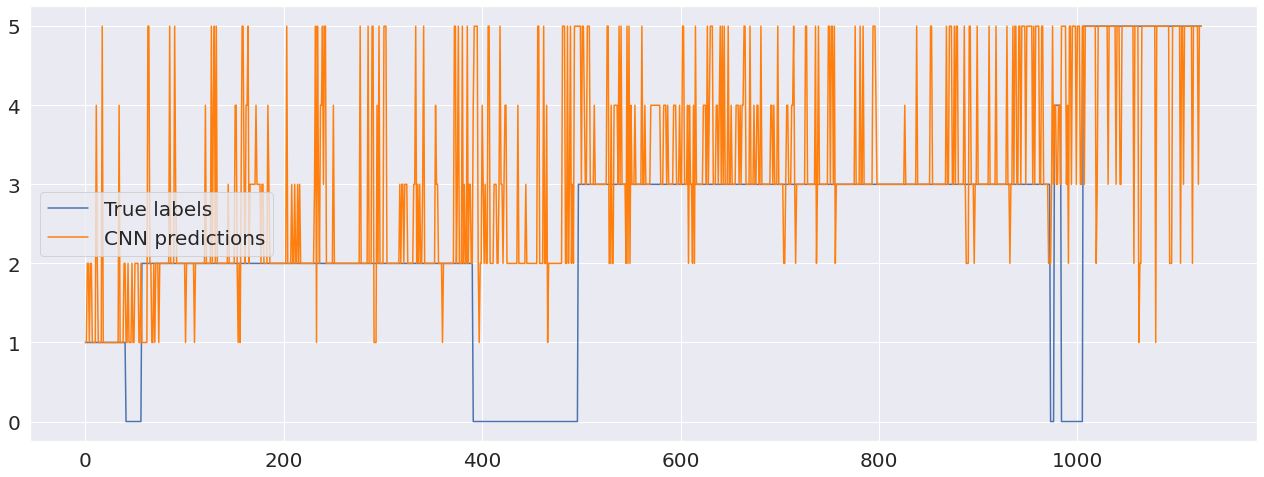

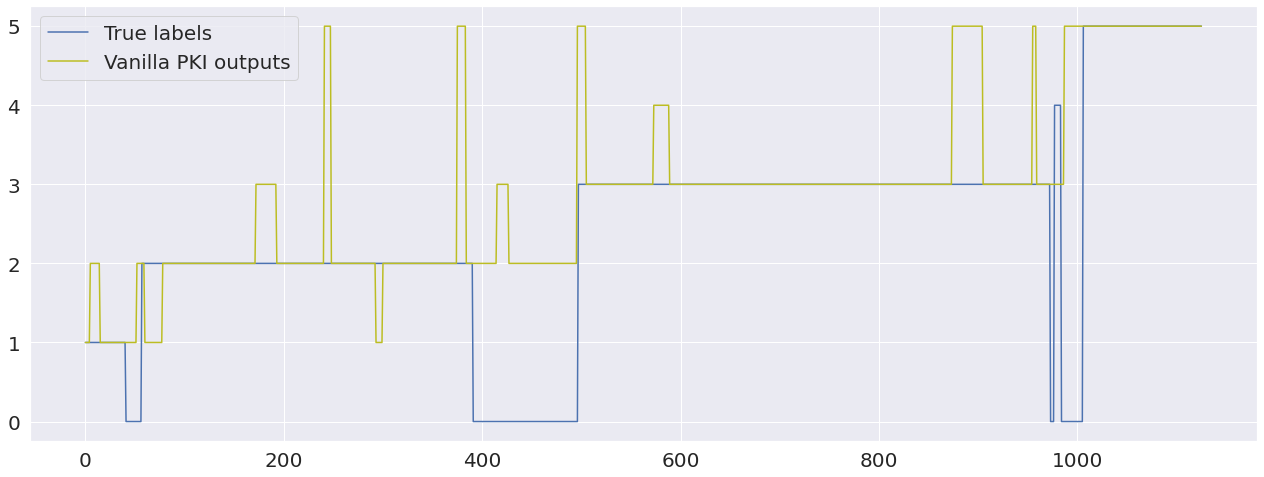

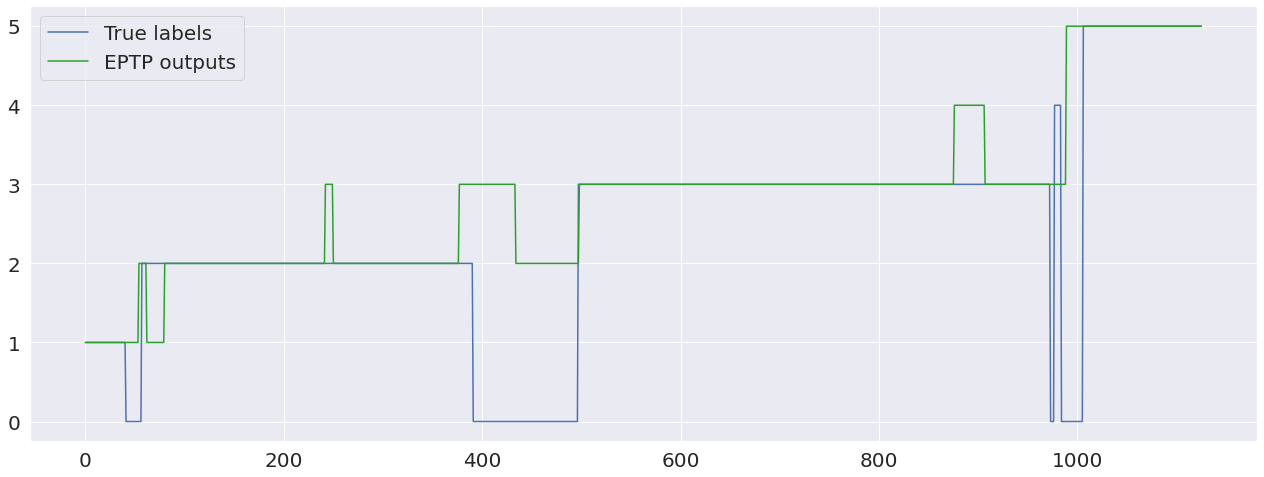

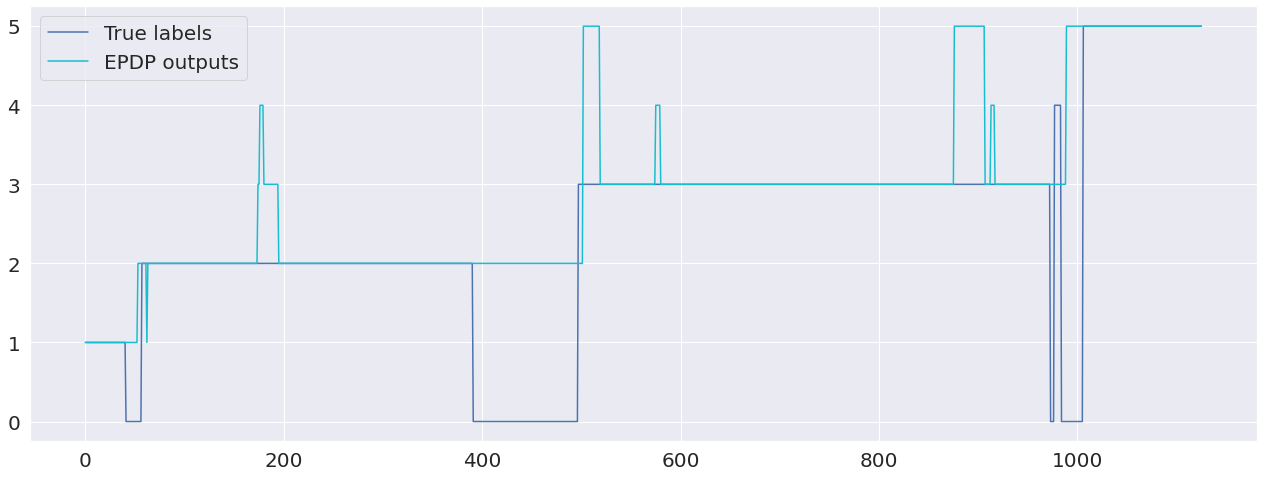

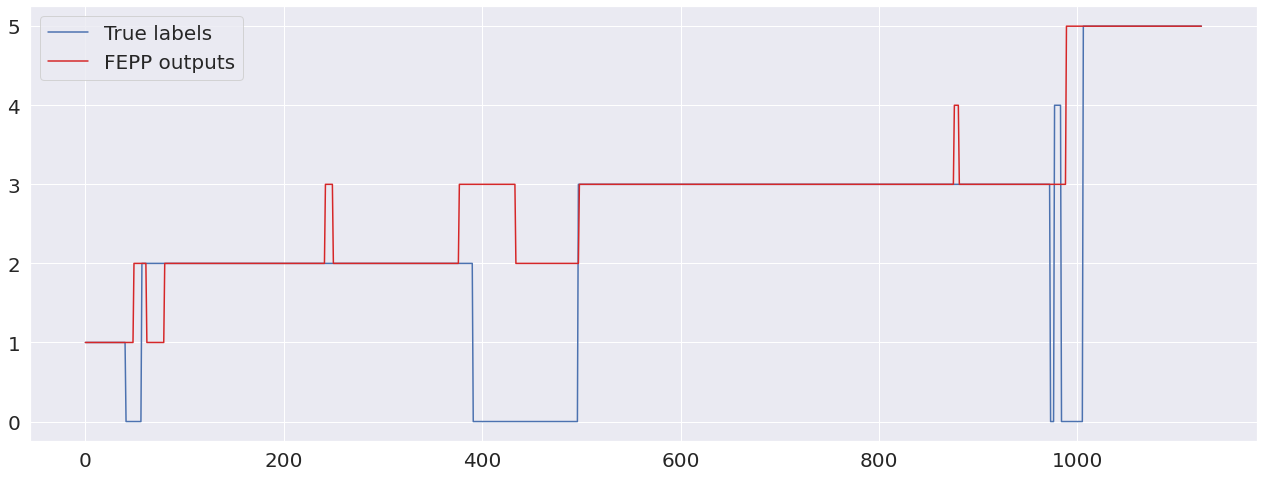

In [227]:
# fold 3:
video_arr = test_folds[3]
for video in video_arr:
    print("Fold 3 Video {}".format(video))
    y_true = true_label_dict[video]
    cnn_pred = pred_label_dict[video]

    plotCnnPred(cnn_pred, y_true)
    for model in names:
        y_model = pki_outputs[model][video]
        plotOutput(model, y_model, y_true)

Fold 6 Video 5238ac7b-ad85-488f-b013-9ee4e2064e60


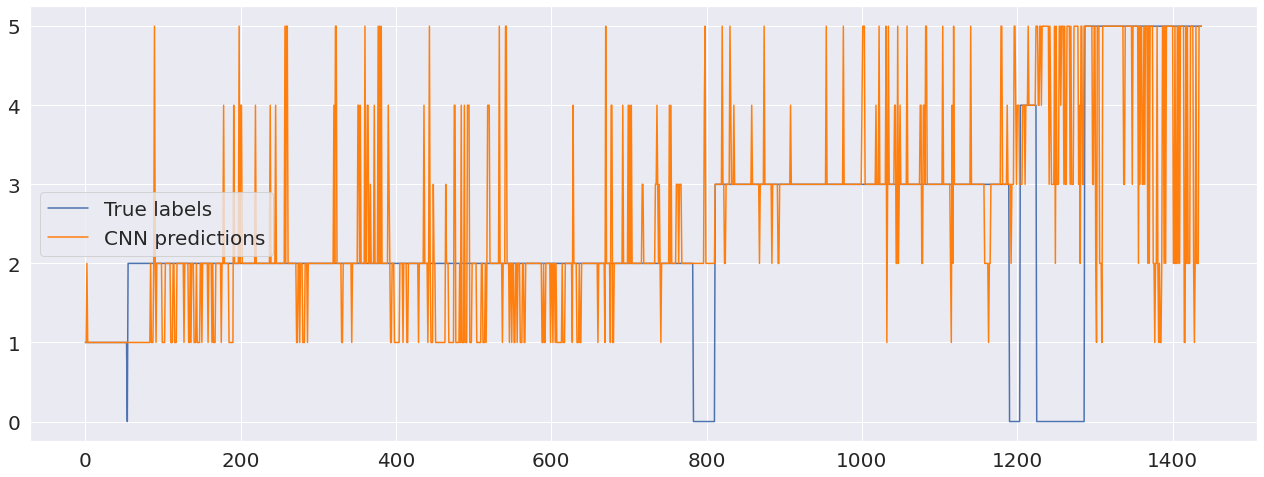

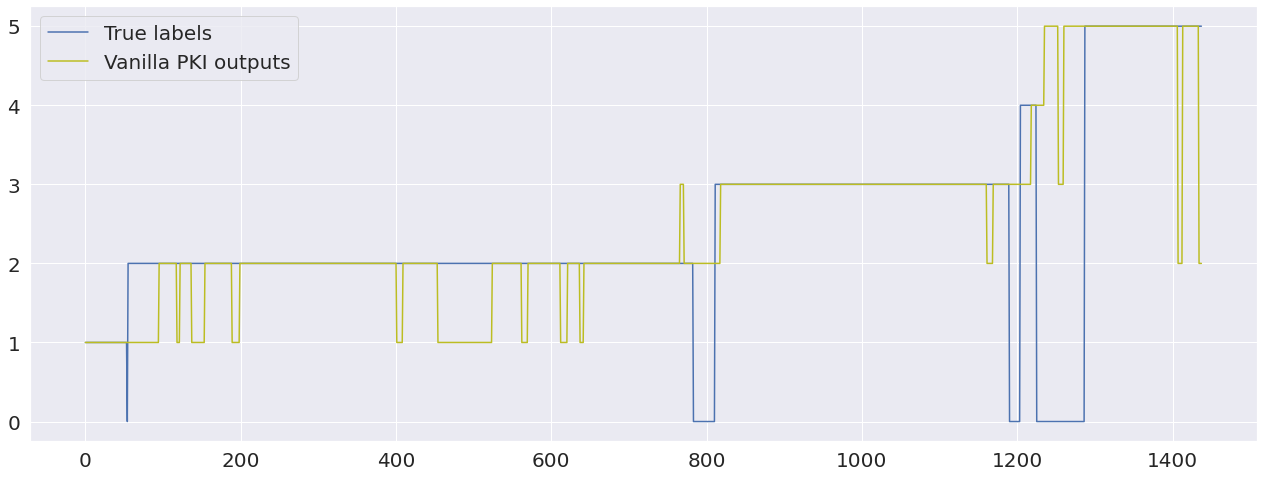

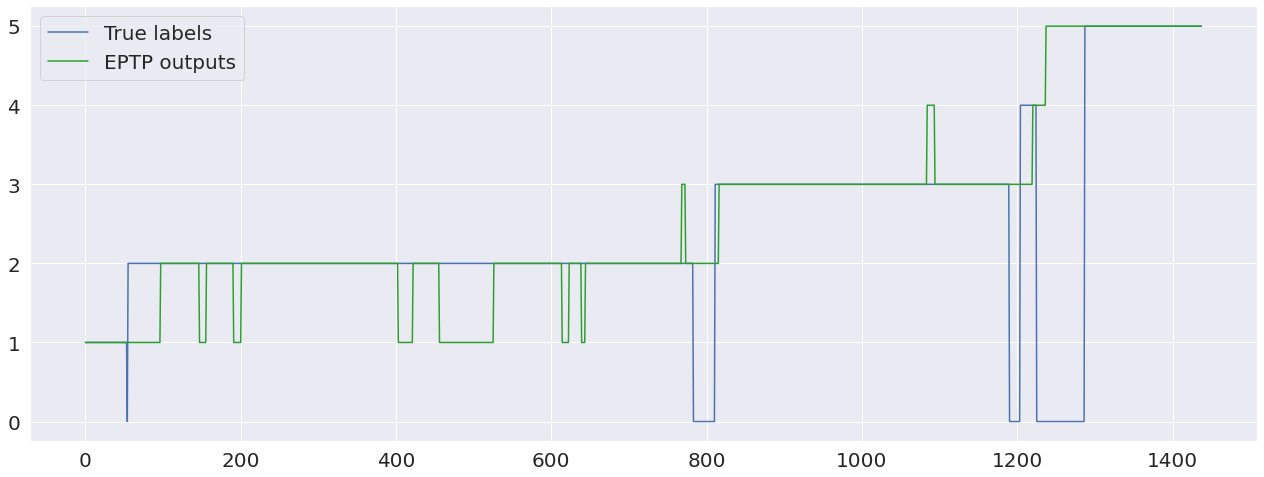

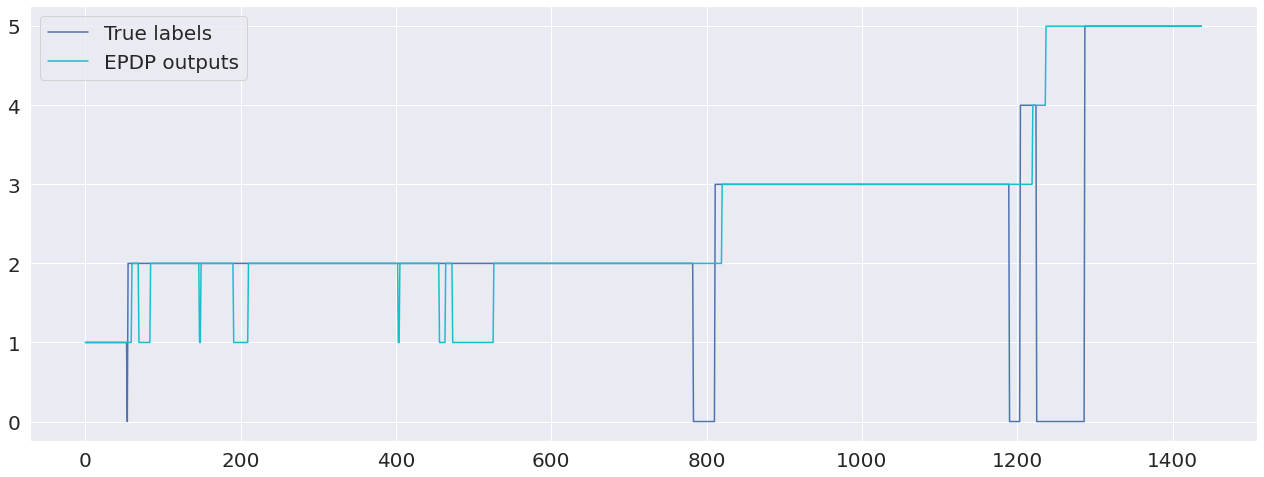

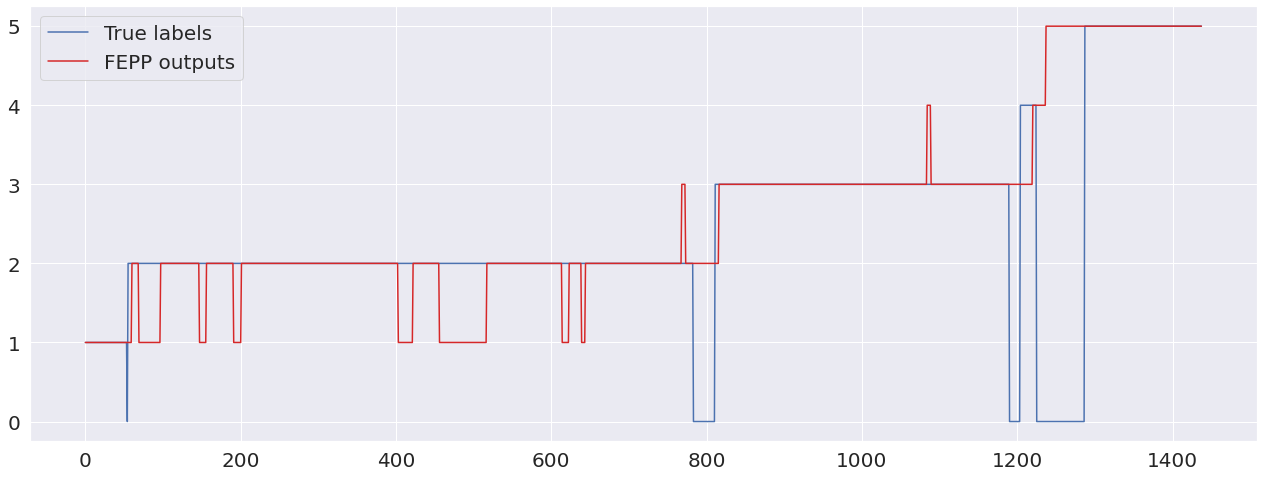

Fold 6 Video 436c714b-b588-4894-b68c-1e0f773e5df1


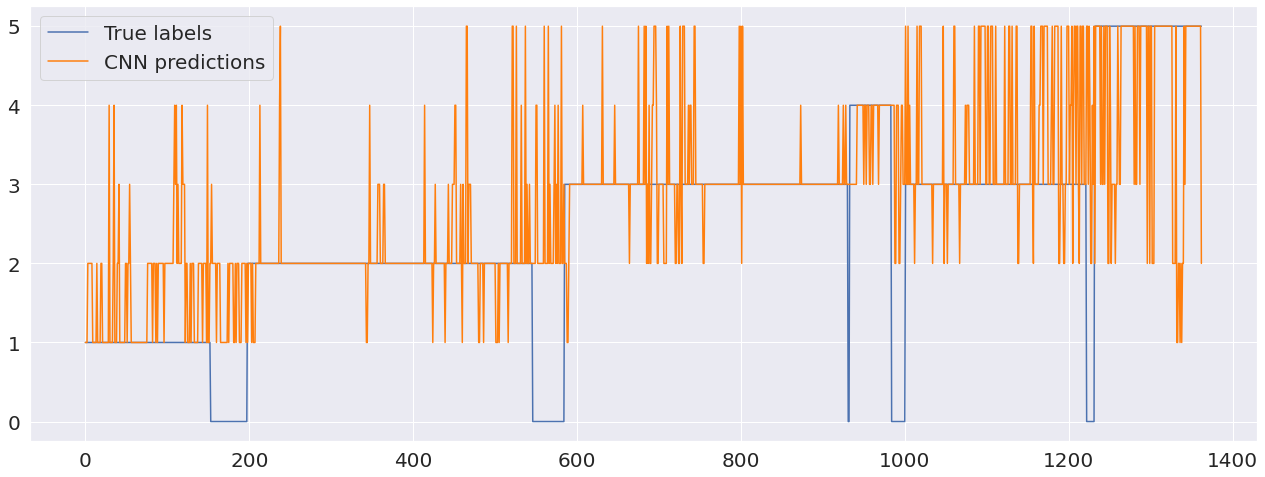

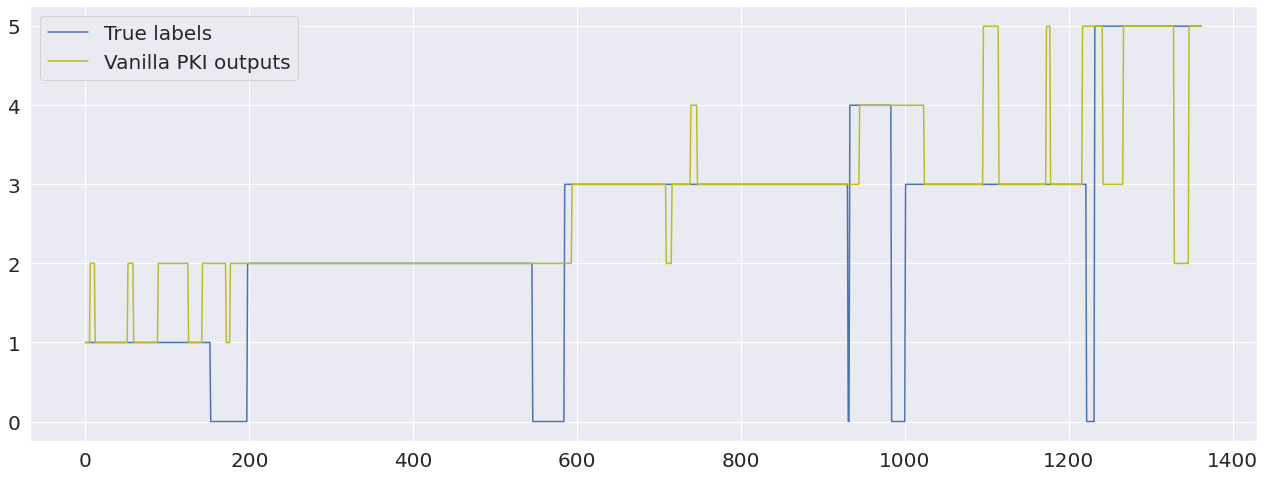

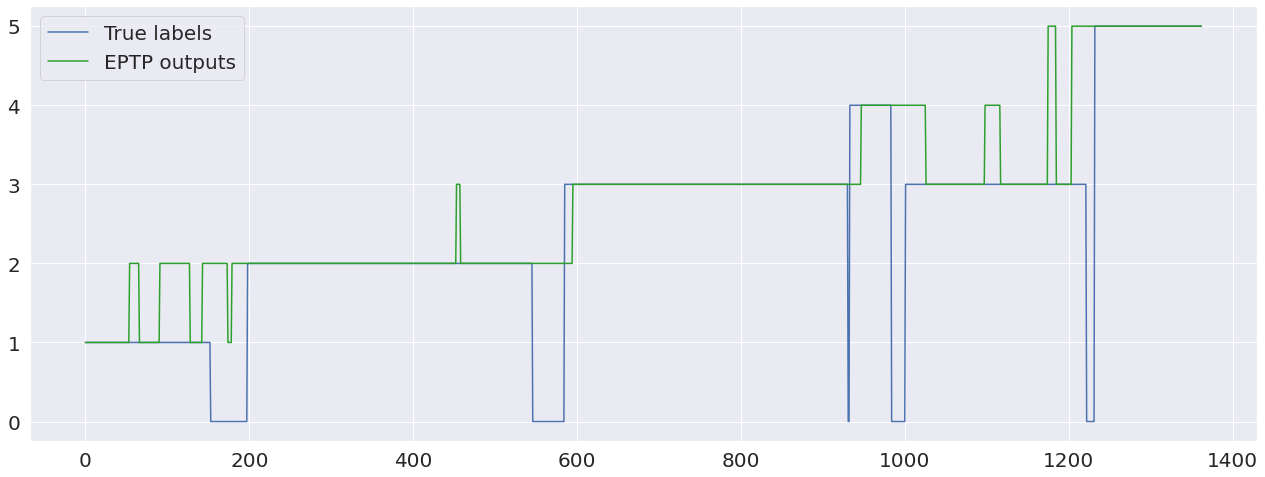

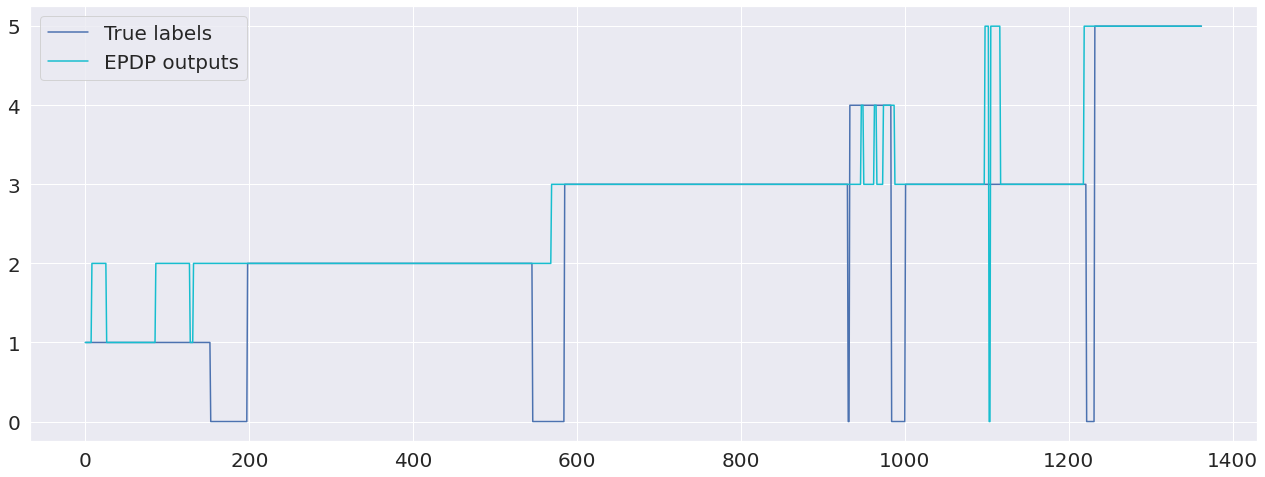

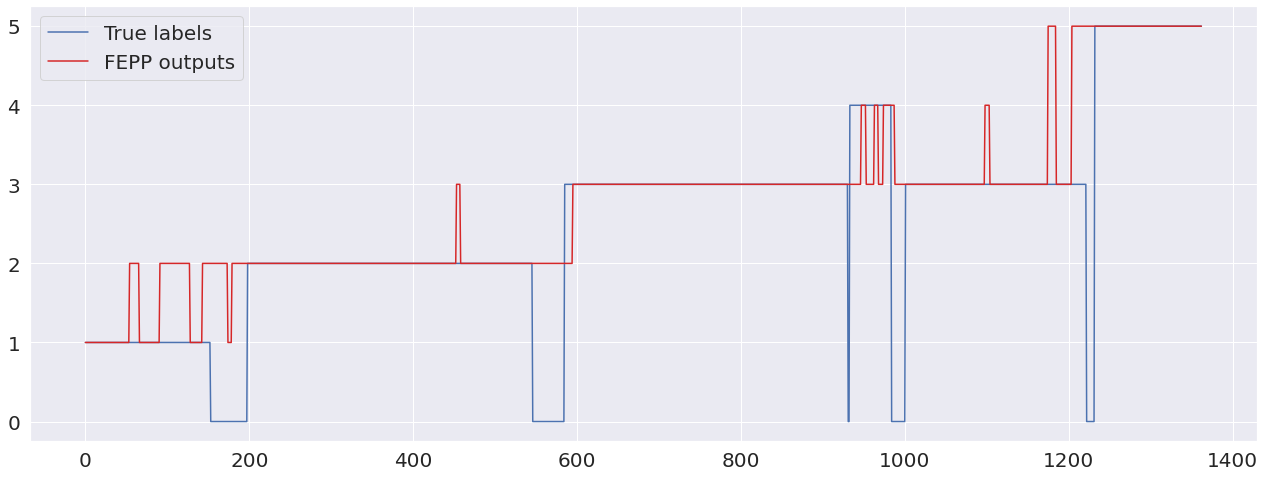

In [230]:
# fold 6:
video_arr = test_folds[6]
for video in video_arr:
    print("Fold 6 Video {}".format(video))
    y_true = true_label_dict[video]
    cnn_pred = pred_label_dict[video]

    plotCnnPred(cnn_pred, y_true)
    for model in names:
        y_model = pki_outputs[model][video]
        plotOutput(model, y_model, y_true)